In [1]:
print("Preparing environment...")

import platform

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from astropy import table as tbl
from astropy import units as u
from astropy.io import fits
from scipy import constants as c
from scipy import interpolate
from tqdm.auto import tqdm

# %matplotlib widget

print("Done.")

Preparing environment...
Done.


In [80]:
### All functions

# Function to use appropriate OS directory structure
def GetDirStruct():
    match platform.system():
        case "Windows":
            dirPrefix = "D:/"
        case "Linux" | "Ubuntu":
            dirPrefix = "/mnt/d/"
        case "macOS" | "Darwin":
            dirPrefix = "/Volumes/Storage/"
        case _:
            raise Exception(f"OS not recognised: \"{platform.system()}\". Please define a custom switch inside GetDirStruct().")
    return dirPrefix


# Function to grab list of spectra in a directory
def GetSpec():
    dirPrefix = GetDirStruct()
    specDir = dirPrefix + specFolder
    specList = !bash -c "ls {specDir}*1D.fits"
    specList = [file.split('/')[-1] for file in specList]
    specNames = [file.split('_')[0] for file in specList]
    return specDir, specList, specNames


# Function to import files to dictionary
def ImportSpec(specDir, specList, specNames):
    specData = {}
    for file, name in tqdm(zip(specList, specNames), desc="Importing spectra", total=len(specList)):
        specRaw = fits.open(specDir + file)
        specFlux = specRaw[1].data * u.Jy
        specWave = specRaw[9].data * u.m
        specData[name] = tbl.QTable([specWave, specFlux], names=("Wavelength", "Flux"))
        specRaw.close()
    return specData


# Function to plot the spectra
def PlotSpec(specData, specList, specNames):
    !bash -c "mkdir -p ../../Working_Directory/Apo_Phot_Utils/{outputFolder}plots"
    for file, name in tqdm(zip(specList, specNames), desc="Plotting galaxies", total=len(specList)):
        plt.plot(specData[name]["Wavelength"], specData[name]["Flux"])
        plt.xscale('log')
        plt.savefig(f"../../Working_Directory/Apo_Phot_Utils/{outputFolder}plots/{name}.png")
        plt.close()
    return

# Function to grab list of filter curves
def GetFilter():
    dirPrefix = GetDirStruct()
    filterDir = dirPrefix + filterFolder
    filterList = !bash -c "ls {filterDir}"
    filterList = [file.split('/')[-1] for file in filterList]
    filterNames = [file.split('_')[0] for file in filterList]
    return filterDir, filterList, filterNames

# Function to import filters to a dictionary
def ImportFilter(filterDir, filterList, filterNames):
    filterData = {}
    for file, name in tqdm(zip(filterList, filterNames), desc="Importing filters", total=len(filterList)):
        filterData[name] = tbl.QTable.read(filterDir + file, format="ascii")
        filterData[name]["Microns"].unit = u.um
        filterData[name].rename_column("Microns", "Wavelength")
    return filterData

# Function to grab list of photometry tables
def GetPhot():
    photList = !bash -c "ls {photDir}*_summary.fits"
    photList = [file.split('/')[-1] for file in photList]
    photNames = [file.split('_')[0] for file in photList]
    return photList, photNames

# Function to grab photometry files
def ImportPhot(photList, photNames):
    photData = {}
    for file, name in tqdm(zip(photList, photNames), desc="Importing photometry", total=len(photList)):
        photData[name] = tbl.QTable.read(photDir + file)
        photData[name].keep_columns(["ID", "Actual Flux", "Flux Error"])
    return photData

# Function to parse tables and set any rows with NaNs to zero, to avoid errors
def RemoveNaNs(tableObj):
    for col in tableObj.colnames:
        for x in range(0, len(tableObj[col]), 1):
            if np.isnan(tableObj[col][x]):
                tableObj[col][x] = 0
    return tableObj

# Function to interpolate datapoints
def InterpFunc(funcXs, funcYs):
    funcCubic = interpolate.interp1d(funcXs, funcYs, kind='cubic')
    return funcCubic

# Function to find grid overlap for convolutions of target using input
def FindGrid(targetGrid, inputGrid, inputData):
    # Sort all arrays
    idxSorted = np.argsort(inputGrid)
    sortedGrid = inputGrid[idxSorted]
    sortedTarget = np.sort(targetGrid)
    # Find first value in input that overlaps with target
    if sortedGrid[0] < sortedTarget[0]:
        idxLeft = np.searchsorted(sortedGrid, sortedTarget[0], side="right")
        if inputGrid[idxLeft-1] == sortedTarget[0]:
            idxLeft -= 1
    else:
        idxLeft = 0
    # Find last value in input that overlaps with target
    if sortedGrid[-1] > sortedTarget[-1]:   
        idxRight = np.searchsorted(sortedGrid, sortedTarget[-1], side="left")
        if inputGrid[idxRight] != sortedTarget[-1]:
            idxRight -= 1
    else:
        idxRight = -1
    # Return the section of input that overlaps target
    overlapGrid = sortedGrid[idxLeft:idxRight]
    overlapData = inputData[idxSorted][idxLeft:idxRight]
    return overlapGrid, overlapData

# Function to manage convolution calculation from first array onto second array
def ConvolveFunc(firstXs, firstYs, secondXs, secondYs):
    # Interpolate datapoints of first array
    firstInterp = InterpFunc(firstXs.to(u.m), firstYs)
    # Find relevant convolution grid for first array based on second array
    secondOverlapGrid, secondOverlapData = FindGrid(firstXs, secondXs, secondYs)
    # Convolve first array onto second array's grid
    firstConvolved = firstInterp(secondOverlapGrid.to(u.m))
    return firstConvolved, secondOverlapGrid, secondOverlapData

# Function to convolve spectra and filters onto same grid
def MergeGrids(specFile, filterFile):
    specWave = specFile["Wavelength"]
    specFlux = specFile["Flux"]
    filterWave = filterFile["Wavelength"]
    filterThrough = filterFile["Throughput"]
    # Find mutual overlaps
    specConvolved, filterOverlapGrid, filterOverlapData = ConvolveFunc(specWave, specFlux, filterWave, filterThrough)
    filterConvolved, specOverlapGrid, specOverlapData = ConvolveFunc(filterWave, filterThrough, specWave, specFlux)
    # Save as tables
    specTable = tbl.Table([np.append(specOverlapGrid, filterOverlapGrid).to(u.m), np.append(specOverlapData, specConvolved*u.Jy)], names=("Wavelength", "Flux"))
    specTable.sort("Wavelength")
    filterTable = tbl.Table([np.append(filterOverlapGrid, specOverlapGrid).to(u.m), np.append(filterOverlapData, filterConvolved)], names=("Wavelength", "Throughput"))
    filterTable.sort("Wavelength")
    # Join tables
    mergedTable = tbl.join(specTable, filterTable, keys="Wavelength")
    return mergedTable

# Function to shift flux to photon space
def ShiftPhotonSpace(mergedTable):
    mergedTable["Flux"] *= mergedTable["Wavelength"]
    return mergedTable

# Function to integrate two functions on the same grid
def IntegFunc(firstYs, secondYs, commonGrid):
    funcIntegrated = np.trapz(firstYs * secondYs, x=commonGrid)
    return funcIntegrated

# Function to normalise the throughput to the correct zero-point
def NormaliseValue(specTable, specValue):
    specThrough = specTable["Throughput"]
    specGrid = specTable["Wavelength"]
    # norm_ref = 10**(48.6/(-2.5)) # reference zero magnitude
    normRef = 1 * u.Jy.to(u.W / ((u.m)**2 * u.Hz)) * 10**(-6) # reference flat-value in f_nu
    normYs = normRef * c.c / specGrid**2 * specGrid # not squared, f_lambda in photon_space
    normValue = IntegFunc(specThrough, normYs, specGrid)
    specNormed = specValue / normValue
    return specNormed

# Function to calculate throughput on a merged grid
def CalcThroughput(mergedTable):
    mergedWave = mergedTable["Wavelength"]
    mergedFlux = mergedTable["Flux"]
    mergedThrough = mergedTable["Throughput"]
    mergedOut = IntegFunc(mergedFlux, mergedThrough, mergedWave)
    return mergedOut

# Function to find throughput given a spectrum and filter
def FindThroughput(specFile, filterFile):
    # Convolve onto the same grid
    mergedTable = MergeGrids(specFile, filterFile)
    # Shift to photon space
    mergedTable = ShiftPhotonSpace(mergedTable)
    # Integrate through the filter
    return CalcThroughput(mergedTable), mergedTable

def BalmerBreak(specFile, specName, redshiftFile):
    # Define regions
    balmerLeftRange = np.array([3500, 3650]) * u.angstrom
    balmerRightRange = np.array([3800, 3950]) * u.angstrom
    # Grab relevant grids
    for row in range(0, len(redshiftFile), 1):
        if int(specName) == int(redshiftFile[row][redshiftID]) and redshiftFile[row][redshiftZ] > 0:
            redshiftFactor = 1 + redshiftFile[row][redshiftZ]
            break
        else:
            redshiftFactor = np.nan
    if redshiftFactor != 0:
        balmerLeftWave, balmerLeftSpec = FindGrid(balmerLeftRange, specFile["Wavelength"]/redshiftFactor, specFile["Flux"]*redshiftFactor)
        balmerRightWave, balmerRightSpec = FindGrid(balmerRightRange, specFile["Wavelength"]/redshiftFactor, specFile["Flux"]*redshiftFactor)
        # Shift to photon space
        balmerLeftSpec *= balmerLeftWave
        balmerRightSpec *= balmerRightWave
        # Calculate average flux
        balmerLeftVal = np.sum(balmerLeftSpec) / len(balmerLeftSpec)
        balmerRightVal = np.sum(balmerRightSpec) / len(balmerRightSpec)
        # Calculate ratio
        balmerRatio = balmerRightVal/balmerLeftVal
        balmerVals = [balmerLeftVal, balmerRightVal, balmerRatio]
    return balmerVals

# Function to loop through filters and balmer breaks for one spectrum
def HandleSpectrum(specFile, specName, filterData, redshiftFile):
    specValues = []
    for filter in filterData.values():
        specValue, specTable = FindThroughput(specFile, filter)
        specValues += [NormaliseValue(specTable, specValue)]
    specValues += BalmerBreak(specFile, specName, redshiftFile)
    return specValues

# Function to loop through each spectrum and save values to a table
def LoopSpectra(specData, filterData, redshiftFile):
    !bash -c "mkdir -p ../../Working_Directory/Apo_Phot_Utils/{outputFolder}"
    rows = []
    for specName, specFull in tqdm(zip(specData.keys(), specData.values()), desc="Galaxies", total=len(specData.keys())):
        rows += [[int(specName)] + HandleSpectrum(specFull, specName, filterData, redshiftFile)]
    names = ["ID"] + list(filterData.keys()) + ["Balmer_left", "Balmer_right", "Balmer_ratio"]
    outTable = tbl.Table(rows=rows, names=names)
    outTable.write(f"../../Working_Directory/Apo_Phot_Utils/{outputFolder}throughputs.fits", overwrite=True)
    return

# Function to join photometry into master table
def JoinPhot(photData, photNames):
    for name in photNames:
        try:
            photTable
        except NameError:
            photTable = tbl.Table(photData[name])
        else:
            photTable = tbl.join(photTable, photData[name], keys="ID")
        photTable.rename_column("Actual Flux", f"{name} Flux")
        photTable.rename_column("Flux Error", f"{name} Error")
    return photTable

Importing data...
Cleaning data...


Cleaning spectra:   0%|          | 0/253 [00:00<?, ?it/s]

Cleaning filters:   0%|          | 0/30 [00:00<?, ?it/s]

Plotting images...


Plotting galaxies:   0%|          | 0/253 [00:00<?, ?it/s]

KeyboardInterrupt: 

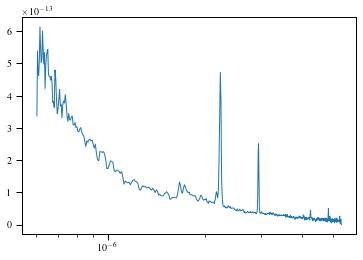

In [15]:
print("Importing data...")

# Directories
try:
    filterFolder
    specFolder
    outputFolder
except NameError:
    filterFolder = "Throughputs/nircam_throughputs/mean_throughputs/"
    specFolder = "Spectra/HST_Deep/prism_v1.5/"
    outputFolder = "HST_Deep/prism_v1.5/"

# Spectra
try:
    specData
except NameError:
    specDir, specList, specNames = GetSpec()
    specData = ImportSpec(specDir, specList, specNames)

# Filters
try:
    filterData
except NameError:
    filterDir, filterList, filterNames = GetFilter()
    filterData = ImportFilter(filterDir, filterList, filterNames)

# Redshift catalogue
try:
    redshiftFile
except NameError:
    redshiftFolder = GetDirStruct() + "Redshifts/Deep_HST.csv"
    redshiftID = "ID"
    redshiftZ = "Assigned_redshift"
    redshiftFile = tbl.Table.read(redshiftFolder)

print("Cleaning data...")

for spectrum in tqdm(specData.values(), desc="Cleaning spectra"):
    spectrum = RemoveNaNs(spectrum)
for filterFile in tqdm(filterData.values(), desc="Cleaning filters"):
    filterFile = RemoveNaNs(filterFile)

print("Plotting images...")

PlotSpec(specData, specList, specNames)

print("Calculating throughputs...")

LoopSpectra(specData, filterData, redshiftFile)

print("Done.")

In [81]:
print("Importing galaxies...")

# Directories
try:
    filterFolder
    specFolder
    outputFolder
    photDir
except NameError:
    filterFolder = "Throughputs/nircam_throughputs/mean_throughputs/"
    specFolder = "Spectra/HST_Deep/prism_v1.5/"
    outputFolder = "HST_Deep/prism_v1.5/"
    photDir = "../../Working_Directory/Apo_Phot/HST_Deep/"

# Spectra
try:
    specData
except NameError:
    specDir, specList, specNames = GetSpec()
    specData = ImportSpec(specList, specDir, specNames)

# Filters
try:
    filterData
except NameError:
    filterDir, filterList, filterNames = GetFilter()
    filterData = ImportFilter(filterDir, filterList, filterNames)
    
# Photometry
# try:
#     photData
# except NameError:
photList, photNames = GetPhot()
photData = ImportPhot(photList, photNames)
photTable = JoinPhot(photData, photNames)

Importing galaxies...


Importing photometry:   0%|          | 0/14 [00:00<?, ?it/s]

In [82]:
photTable

ID,F090W Flux,F090W Error,F115W Flux,F115W Error,F150W Flux,F150W Error,F182M Flux,F182M Error,F200W Flux,F200W Error,F210M Flux,F210M Error,F277W Flux,F277W Error,F335M Flux,F335M Error,F356W Flux,F356W Error,F410M Flux,F410M Error,F430M Flux,F430M Error,F444W Flux,F444W Error,F460M Flux,F460M Error,F480M Flux,F480M Error
,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2332,0.003152352787088139,0.0017957765351233237,0.0057456327572303475,0.001257317113252856,0.008420597263194917,0.0015011993654089274,0.0,0.0,0.013173230277466976,0.001248221480034125,0.0,0.0,0.011894123478347776,0.0004573211340373981,0.008511616386291387,0.0006032528713009376,0.011437066769689357,0.0004312572864855359,0.012679910693414802,0.000796994384893799,0.0,0.0,0.009528908277399458,0.0006543791526634901,0.0,0.0,0.0,0.0
2375,0.009697443612337573,0.001294801517356784,0.016806098211432134,0.0008975045569903119,0.020953497781306625,0.0010822656704993648,0.0,0.0,0.02152639339496018,0.0008956512109674895,0.0,0.0,0.019961276430127566,0.0003156167384038272,0.019228238073688113,0.0004357754537572977,0.01890898001653729,0.0002992742855159896,0.01724219437452738,0.0005594524607000461,0.0,0.0,0.019004589363852735,0.0004681490646533332,0.0,0.0,0.0,0.0
2528,0.002784590145109872,0.0009799849042717663,0.007293493813621581,0.0006919210255639927,0.01120334791834654,0.0008159892471870225,0.0,0.0,0.010678649978038083,0.0006725662788813682,0.0,0.0,0.010962306969542404,0.000277535482669634,0.009200437238444364,0.0003545381222005805,0.00882185343997626,0.0002483015114180146,0.00803795324450619,0.0004954284835942887,0.0,0.0,0.008014172346439107,0.00041943600904055625,0.0,0.0,0.0,0.0
2651,0.002181144381909145,0.0012835905219712965,0.005816713383646497,0.0008961174165977499,0.004188858542971953,0.0010705750680235196,0.0,0.0,0.006784560931228078,0.0008748287141063095,0.0,0.0,0.008549298757335627,0.00031798472665447444,0.0055083175220121145,0.00041604436495470704,0.005577542923109023,0.00029399271221934077,0.005691993035345984,0.0005492143921099797,0.0,0.0,0.004843493456093821,0.0004636289581926643,0.0,0.0,0.0,0.0
2773,0.00035107380882096824,0.0009926898997915533,0.00038416621174653434,0.000747800615826512,0.0011681654509768298,0.0008346799451555534,0.0,0.0,0.0067086217956683555,0.0008347717783211318,0.0,0.0,0.006052532111410938,0.0002582724535261908,0.004343789708938153,0.0004210926519626203,0.005880581453459733,0.00029514201268342015,0.0046565463371237735,0.0004578670178963165,0.0,0.0,0.004529685035535451,0.00038550110575599593,0.0,0.0,0.0,0.0
2923,0.01522334020144985,0.0013036438520963667,0.012369862768375938,0.0009013210594980885,0.012309532605656058,0.0010782642400396305,-6.897965071655864e-08,0.0,0.017128352948318472,0.0008801237143638893,-1.1509539363611485e-08,0.0,0.014192773165881564,0.00031878038566999345,0.008473176670619245,0.00042233251635097314,0.008664902283173698,0.00030181584862125637,0.006851836712659501,0.0005532018350844249,0.0,0.0,0.008123794679319918,0.0004716324451839653,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10105275,0.0004924459295901046,0.0007504782382074576,-4.3495105524537916e-05,0.0005731927917242767,0.0011905267904274211,0.0006253076156411601,-0.0012294854405899476,0.0011017388196664845,-0.0010868050229149902,0.0006096440228930978,0.0014245071077295941,0.0011938489866875131,-9.972832686813544e-05,0.00018487048770039814,-0.00013194578292290607,0.000298360397827507,0.00034820782891493204,0.0002071546575346663,-0.00045569011749831123,0.0003264887191259267,0.001329307859053589,0.0011766442209621985,6.525925242613637e-05,0.00027686234577587213,-0.004611704832934986,0.001696516

In [67]:
photData["F090W"]

ID,Actual Flux,Flux Error
,uJy,uJy
int64,float64,float64
2332,0.003152352787088139,0.0017957765351233237
2375,0.009697443612337573,0.001294801517356784
2528,0.002784590145109872,0.0009799849042717663
2651,0.002181144381909145,0.0012835905219712965
2773,0.00035107380882096824,0.0009926898997915533
2923,0.01522334020144985,0.0013036438520963667
...,...,...
10105275,0.0004924459295901046,0.0007504782382074576


In [25]:
testPrefix = "/Volumes/Storage/Slit-losses/HST/pathlosses_deep_R100/R100_v0/p01/pathlosses_correction_deep_hst_1x1_p01_exp00_idcat_"
testSuffix = "_v0_point.txt"

In [51]:
lossesList = !bash -c "ls {testPrefix}*{testSuffix}"
lossesList = [file.split('/')[-1] for file in lossesList]
lossesList = [file.split('_')[-3] for file in lossesList]
lossesNames = [file[5:11] for file in lossesList]
lossesIDs = [int(file) for file in lossesNames]
lossesTable = tbl.Table([lossesIDs, lossesNames], names=("ID", "Name"))
lossesTable.add_column(("pathlosses_correction_deep_hst_1x1_p01_exp00_idcat_" + lossesTable["Name"] + testSuffix), name=("fileName"))

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U51'), dtype('<U6')) -> None

In [49]:
lossesTable.write("lossesTable.csv")

In [24]:
photNames

['F090W',
 'F115W',
 'F150W',
 'F182M',
 'F200W',
 'F210M',
 'F277W',
 'F335M',
 'F356W',
 'F410M',
 'F430M',
 'F444W',
 'F460M',
 'F480M']

In [ ]:
plt.close("all")

# plt.plot(Spectrum["Wavelength"], Spectrum["Flux"])
# plt.plot(Filter["Wavelength"], Filter["Throughput"] * 10 **(-13))
plt.plot(Filter_grid, Filter_conv * 10 ** (-13), color="green")
plt.plot(Filter_grid, Spectrum_flux, color="blue")
plt.plot(Filter_grid, Filter_conv * Spectrum_flux, color="red")